## 1. Importación de Librerías



In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
# Ejecutar una sola vez para descargar las capertas donde viene el dataset
# Y una vez descargado movemos las carpetas de Testing y Training a Nuestra carpeta donde
# vamos a estar trabajando

#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

#print("Path to dataset files:", path)

## 2. Configuración de la Semilla para Reproducibilidad

In [ ]:
# Establecer una semilla nos ayuda a obtener los mismos resultados cada vez que ejecutamos el código.
# Es crucial para la depuración y para comparar el rendimiento de diferentes modelos de manera justa.
seed_value = 42


random.seed(seed_value)


np.random.seed(seed_value)


tf.random.set_seed(seed_value)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"Semillas de aleatoriedad fijadas en: {seed_value}")
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

Semillas de aleatoriedad fijadas en: 42


## 3. Carga y Preprocesamiento de Datos

In [ ]:
# Definir las rutas a los directorios de entrenamiento y prueba
train_dir = 'Training/'
test_dir = 'Testing/'

# --- Definir constantes para el preprocesamiento ---
IMG_SIZE = (150, 150) # Tamaño estándar para todas las imágenes
BATCH_SIZE = 32       # Número de imágenes a procesar en cada lote
# La variable seed_value se definió en la celda anterior para garantizar la reproducibilidad
SEED = seed_value

# --- Data Augmentation---

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normaliza los pixeles de las imágenes a un rango de [0, 1]
    rotation_range=10,              # Gira las imágenes aleatoriamente hasta 10 grados
    brightness_range=(0.85, 1.15),  # Cambia el brillo de la imagen aleatoriamente
    width_shift_range=0.002,        # Desplaza las imágenes horizontalmente (un valor muy pequeño)
    height_shift_range=0.002,       # Desplaza las imágenes verticalmente (un valor muy pequeño)
    shear_range=12.5,               # Aplica cortes (transformaciones de cizallamiento)
    zoom_range=0,                   # No se aplica zoom aleatorio
    horizontal_flip=True,           # Invierte las imágenes horizontalmente
    vertical_flip=False,            # No se invierten las imágenes verticalmente
    fill_mode="nearest"             # Rellena los nuevos pixeles que puedan aparecer
)

# --- Generador de Datos de Prueba ---
# Para el conjunto de prueba, solo necesitamos normalizar los pixeles.
test_datagen = ImageDataGenerator(rescale=1./255)


# --- Aplicar los generadores a los datos ---
# Usamos flow_from_directory para cargar las imágenes, inferir las clases y aplicar las transformaciones.
# Se utiliza la semilla (SEED) para que el barajado y las transformaciones sean reproducibles.
print("Cargando datos de entrenamiento...")
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED
)

print("\n Cargando datos de prueba...")
testing_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False, # Es importante no barajar los datos de prueba para una evaluación consistente
    seed=SEED
)

# Imprimir las clases encontradas
print("\nClases encontradas en el conjunto de entrenamiento:")
print(training_set.class_indices)

Cargando datos de entrenamiento...
Found 5712 images belonging to 4 classes.

Cargando datos de prueba...
Found 1311 images belonging to 4 classes.

Clases encontradas en el conjunto de entrenamiento:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 4. Visualización de los Datos Cargados

C:\Users\nefth\AppData\Local\Temp\ipykernel_21176\3595134254.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax1, palette="viridis")
C:\Users\nefth\AppData\Local\Temp\ipykernel_21176\3595134254.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax2, palette="plasma")


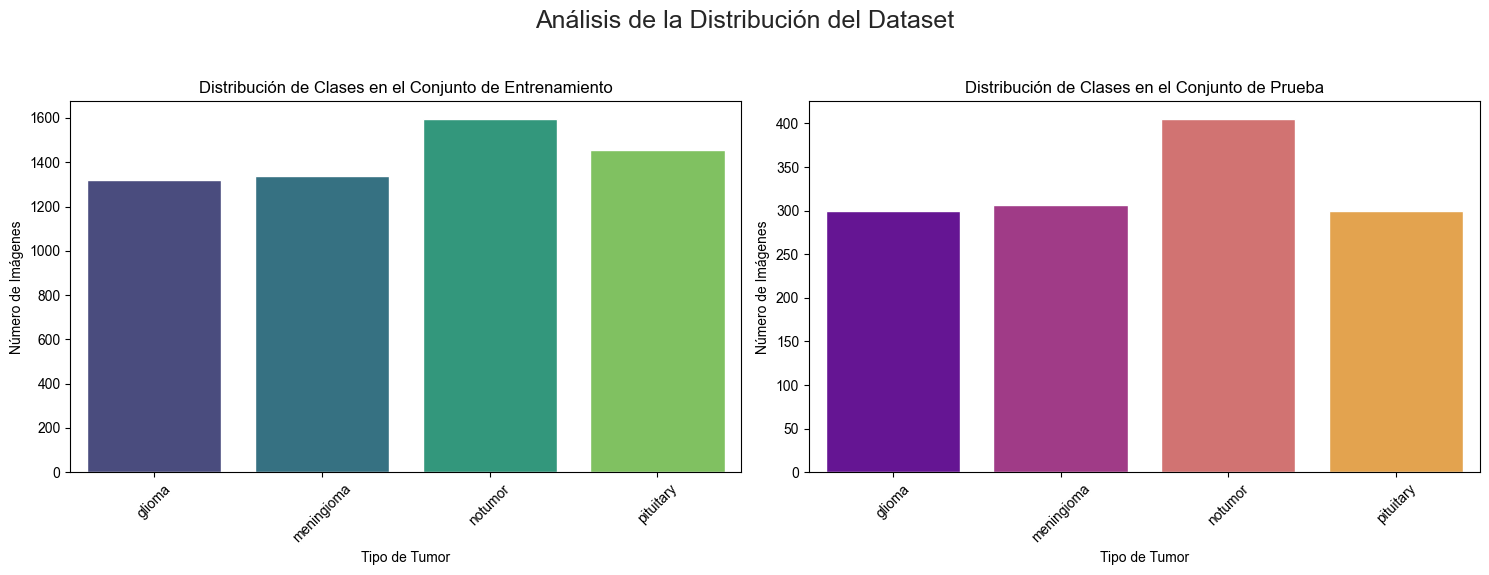

In [23]:
# Función para contar imágenes en cada subdirectorio
def count_images(directory):
    counts = {}
    for subdir in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, subdir)):
            counts[subdir] = len(os.listdir(os.path.join(directory, subdir)))
    return counts

# Contar imágenes en los conjuntos de entrenamiento y prueba
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Crear los gráficos de barras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

# Gráfico para el conjunto de entrenamiento
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax1, palette="viridis")
ax1.set_title('Distribución de Clases en el Conjunto de Entrenamiento')
ax1.set_xlabel('Tipo de Tumor')
ax1.set_ylabel('Número de Imágenes')
ax1.tick_params(axis='x', rotation=45)

# Gráfico para el conjunto de prueba
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax2, palette="plasma")
ax2.set_title('Distribución de Clases en el Conjunto de Prueba')
ax2.set_xlabel('Tipo de Tumor')
ax2.set_ylabel('Número de Imágenes')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Análisis de la Distribución del Dataset', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

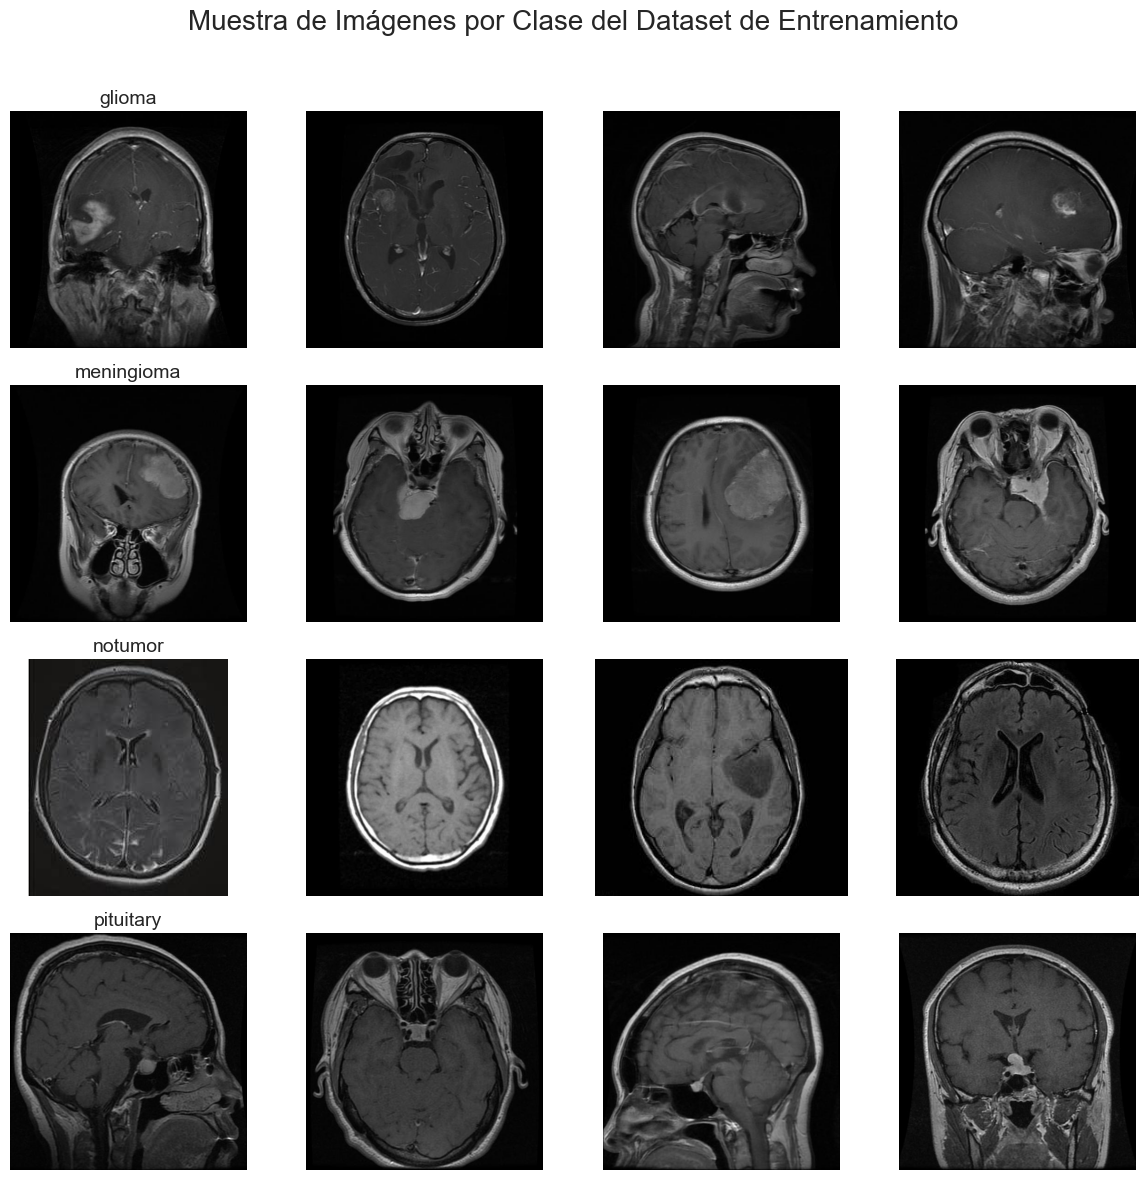

In [24]:
from tensorflow.keras.preprocessing.image import load_img
import random

# Obtener las clases del generador de datos
class_labels = list(training_set.class_indices.keys())

# Crear una figura para mostrar 4x4 imágenes
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Muestra de Imágenes por Clase del Dataset de Entrenamiento', fontsize=20)

for i, label in enumerate(class_labels):
    # Ruta al directorio de la clase
    class_dir = os.path.join(train_dir, label)
    
    # Obtener una lista de imágenes y barajarla para obtener muestras aleatorias
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)
    
    # Mostrar las primeras 4 imágenes de la lista barajada
    for j in range(4):
        if j < len(image_files):
            img_path = os.path.join(class_dir, image_files[j])
            img = load_img(img_path)
            
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            # Poner el nombre de la clase como título de la primera imagen de cada fila
            if j == 0:
                ax.set_title(label, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Definición de las Arquitecturas de los Modelos (CNN)

### Modelo 1: Arquitectura Profunda

In [ ]:
def build_model_1():
    # IMG_SIZE = (150, 150), seed_value = 42, y tenemos 4 clases de tumores.
    image_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    num_classes = 4

    # Define la arquitectura del modelo
    model = models.Sequential()

    # Capa Convolucional 1
    model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Capa Convolucional 2
    model.add(Conv2D(64, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Capa Convolucional 3
    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Capa Convolucional 4
    model.add(Conv2D(128, (4, 4), activation="relu"))

    # Aplanar los mapas de características para la capa densa
    model.add(Flatten())

    # Capas totalmente conectadas (Dense) para la clasificación
    model.add(Dense(512, activation="relu"))
    # Añadimos Dropout para regularización, usando nuestra semilla para reproducibilidad
    model.add(Dropout(0.5, seed=seed_value))
    # Capa de salida con una neurona por cada clase y activación softmax
    model.add(Dense(num_classes, activation="softmax"))

    # Compilamos el modelo con un optimizador, función de pérdida y métricas
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model_1 = build_model_1()
print("Arquitectura del Modelo 1:")
model_1.summary()

c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Arquitectura del Modelo 1:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 2: Arquitectura con Dropout

In [6]:
def build_model_2():
    model = tf.keras.models.Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (4, 4), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (4, 4), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        # Capa Dropout: "Apaga" el 50% de las neuronas para prevenir el sobreajuste.
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = build_model_2()
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 70, 70, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,945,380 (64.64 MB)

 Trainable params: 16,945,380 (64.64 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 3: Arquitectura Profunda con Optimizador Personalizado

In [ ]:
def build_model_3():
    # Usamos las variables que definimos previamente en el notebook
    image_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    num_classes = 4
    
    # Define la arquitectura del modelo
    model = models.Sequential([
        Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5, seed=seed_value),
        Dense(num_classes, activation="softmax")
    ])
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.869,
        beta_2=0.995
    )

    # Compilamos el modelo con el optimizador personalizado
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Construir y mostrar el resumen del nuevo Modelo 3
model_3 = build_model_3()
print("Arquitectura del Modelo 3:")
model_3.summary()

Arquitectura del Modelo 3:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrenamiento y Evaluación de los Modelos

In [8]:
# Entrenamos el modelo usando los generadores de datos que creamos.
# epochs es el número de veces que el modelo verá el conjunto de datos completo.

print("Entrenando el Modelo 1...")
history_1 = model_1.fit(
    training_set,
    epochs=20, 
    validation_data=testing_set
)
print("Entrenando el Modelo 2...")
history_2 = model_2.fit(
    training_set,
    epochs=20, 
    validation_data=testing_set
)
print("Entrenando el Modelo 3...")
history_3 = model_3.fit(
    training_set,
    epochs=20, 
    validation_data=testing_set
)

Entrenando el Modelo 1...


c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 340ms/step - accuracy: 0.4504 - loss: 1.1089 - val_accuracy: 0.7376 - val_loss: 0.6824
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 470ms/step - accuracy: 0.7924 - loss: 0.5371 - val_accuracy: 0.7643 - val_loss: 0.5965
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 470ms/step - accuracy: 0.8332 - loss: 0.4268 - val_accuracy: 0.7170 - val_loss: 0.6790
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 523ms/step - accuracy: 0.8594 - loss: 0.3673 - val_accuracy: 0.8635 - val_loss: 0.3671
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - accuracy: 0.8853 - loss: 0.2962 - val_accuracy: 0.8429 - val_loss: 0.3792
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 481ms/step - accuracy: 0.9114 - loss: 0.2419 - val_accuracy: 0.8970 - val_loss: 0.2598
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.9315 - loss: 0.1898 - val_accuracy: 0.9176 - val_loss: 0.2085
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 476ms/step - accuracy: 0.9439 - loss

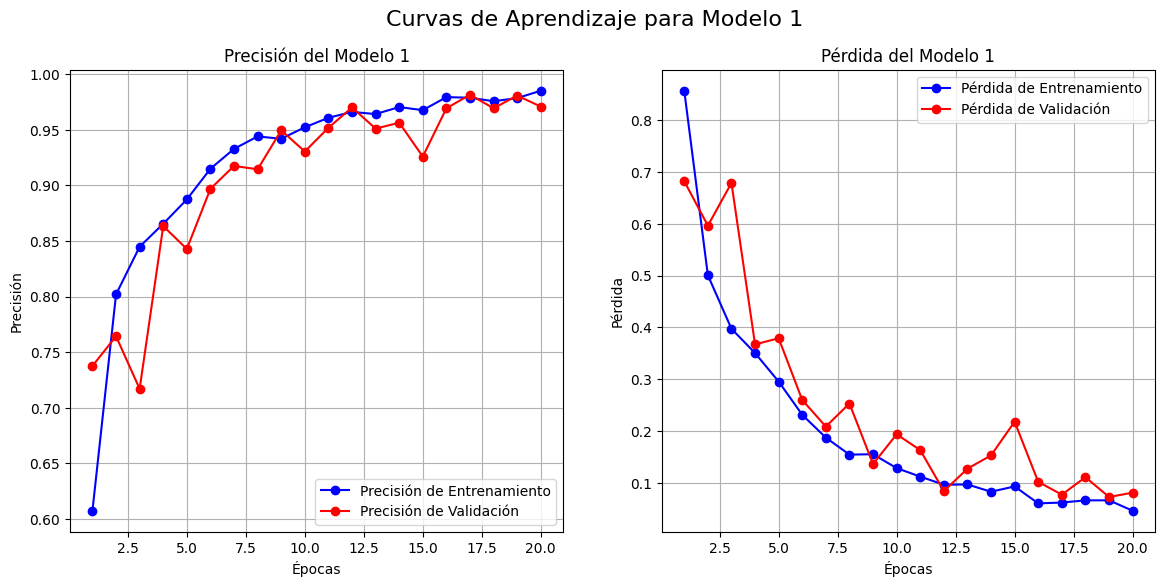

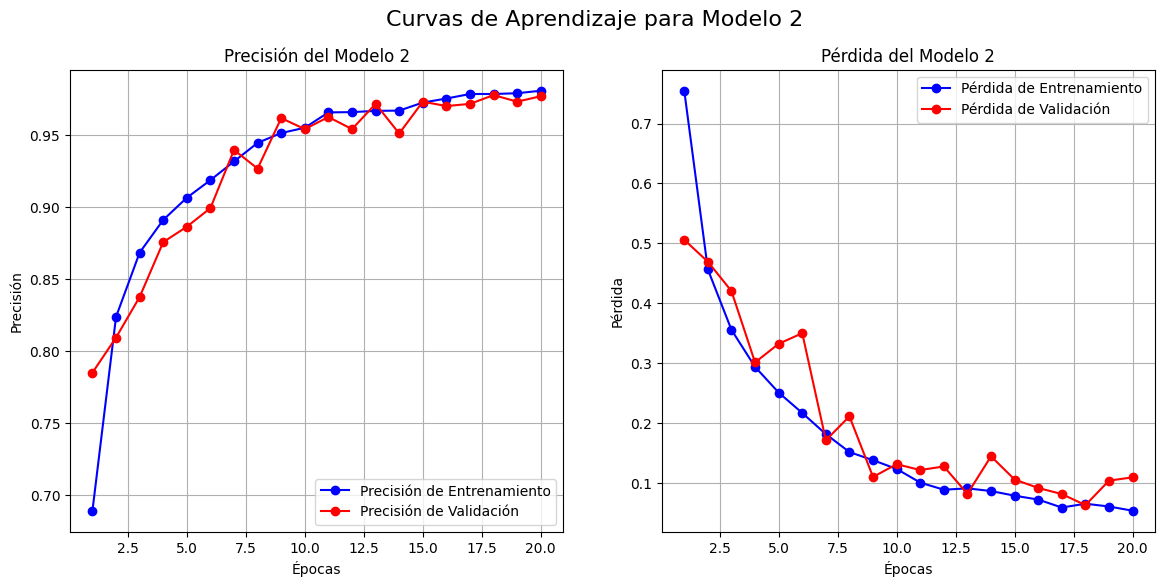

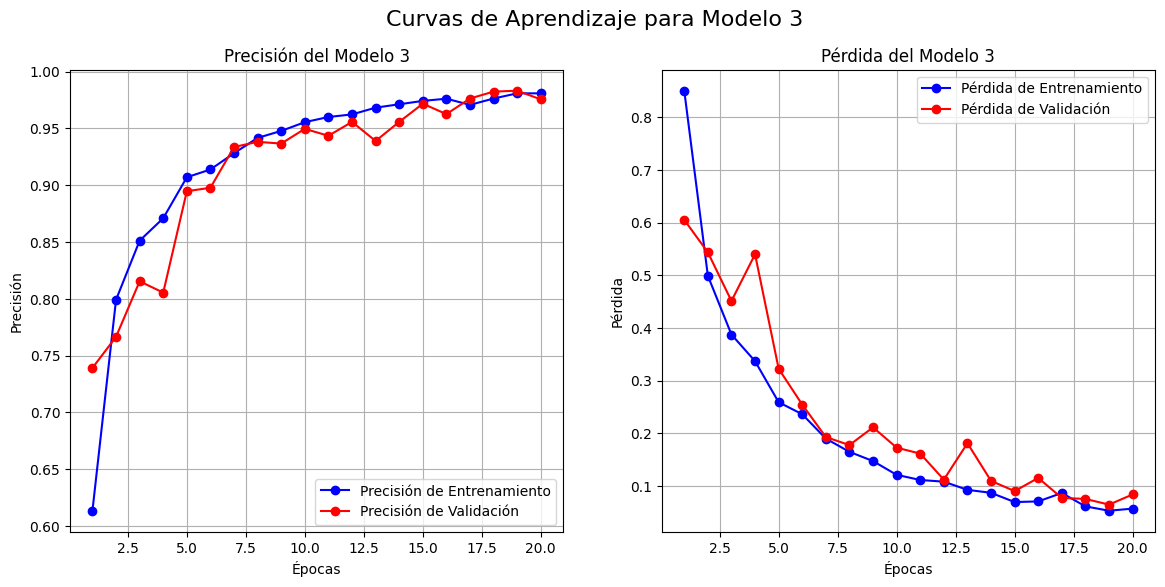

In [9]:
def plot_training_history(history, model_name):
    """
    Función para graficar la precisión y la pérdida de entrenamiento y validación.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Gráfica de Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Precisión de Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Precisión de Validación')
    plt.title(f'Precisión del {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.grid(True)
    plt.legend()

    # Gráfica de Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Pérdida de Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación')
    plt.title(f'Pérdida del {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.legend()

    plt.suptitle(f'Curvas de Aprendizaje para {model_name}', fontsize=16)
    plt.show()

plot_training_history(history_1, "Modelo 1")
plot_training_history(history_2, "Modelo 2")
plot_training_history(history_3, "Modelo 3")

## 7. Evaluación Final Comparativa

In [ ]:
print("Evaluando el rendimiento final del modelo en el conjunto de prueba...")


loss, accuracy = model_1.evaluate(testing_set)
print("Modelo 1")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")
loss, accuracy = model_2.evaluate(testing_set)
print("Modelo 2")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")
loss, accuracy = model_3.evaluate(testing_set)
print("Modelo 3")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")

Evaluando el rendimiento final del modelo en el conjunto de prueba...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9610 - loss: 0.1139
Modelo 1
Pérdida en el conjunto de prueba: 0.0808
Precisión en el conjunto de prueba: 97.10%
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9681 - loss: 0.1474
Modelo 2
Pérdida en el conjunto de prueba: 0.1092
Precisión en el conjunto de prueba: 97.71%
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9663 - loss: 0.1125
Modelo 3
Pérdida en el conjunto de prueba: 0.0837
Precisión en el conjunto de prueba: 97.56%


## 8. Guardar el Mejor Modelo

In [14]:
model_3.save('brain_tumor_classifier_model_3.keras')

## 9. Probar el Modelo Guardado y Visualizar Predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

--- Predicción para una sola imagen ---
Ruta de la imagen: Testing/glioma/Te-gl_0010.jpg
El modelo predice que la clase es: 'glioma'
Confianza de la predicción: 95.60%


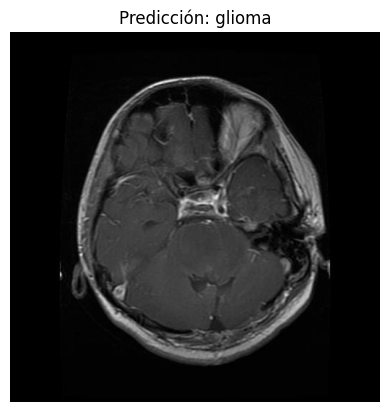

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('brain_tumor_classifier_model_3.keras')

class_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


image_path = 'Testing/glioma/Te-gl_0010.jpg' 
img = load_img(image_path, target_size=(150, 150)) # Cargar y redimensionar
img_array = img_to_array(img)                      # Convertir a un array numpy
img_array = img_array / 255.0                      # Normalizar los pixeles (muy importante)
img_array = np.expand_dims(img_array, axis=0)      # Añadir una dimensión para el lote (batch)


prediction = loaded_model.predict(img_array)


predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]
confidence = np.max(prediction) * 100

print(f"--- Predicción para una sola imagen ---")
print(f"Ruta de la imagen: {image_path}")
print(f"El modelo predice que la clase es: '{predicted_class_label}'")
print(f"Confianza de la predicción: {confidence:.2f}%")

# Mostrar la imagen de prueba
plt.imshow(load_img(image_path))
plt.title(f"Predicción: {predicted_class_label}")
plt.axis('off')
plt.show()


### Reporte de Clasificación y Matriz de Confusión

Generando predicciones para el conjunto de prueba...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       300
  meningioma       0.94      0.97      0.96       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311


--- Matriz de Confusión ---


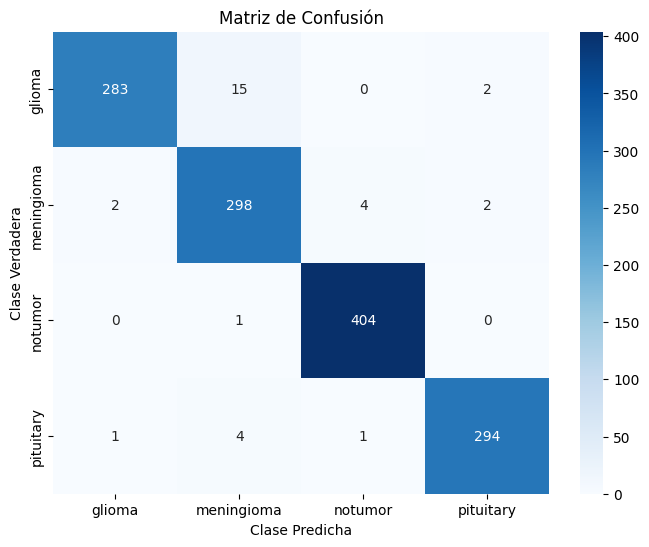

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Obtener las predicciones para todo el conjunto de prueba
# Usamos el modelo cargado para predecir las clases de todas las imágenes en testing_set
print("Generando predicciones para el conjunto de prueba...")
predictions = loaded_model.predict(testing_set)
predicted_classes = np.argmax(predictions, axis=1)

# 2. Obtener las etiquetas verdaderas
true_classes = testing_set.classes
class_labels = list(testing_set.class_indices.keys())

# 3. Imprimir el Reporte de Clasificación
print("\n --- Reporte de Clasificación ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 4. Generar y visualizar la Matriz de Confusión
print("\n --- Matriz de Confusión ---")
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

### Ejemplos de Predicciones Correctas e Incorrectas

Se encontraron 1279 predicciones correctas y 32 incorrectas.
--- Ejemplos de Predicciones Correctas ---


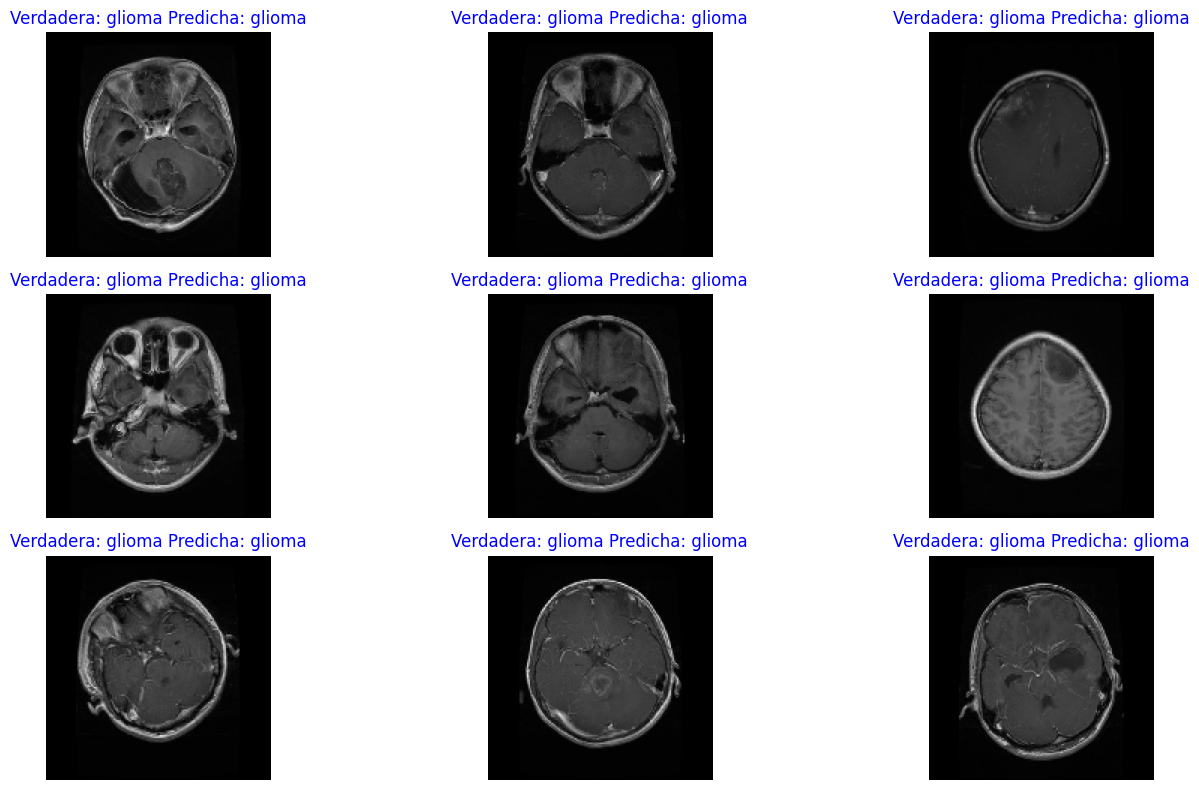

--- Ejemplos de Predicciones Incorrectas ---


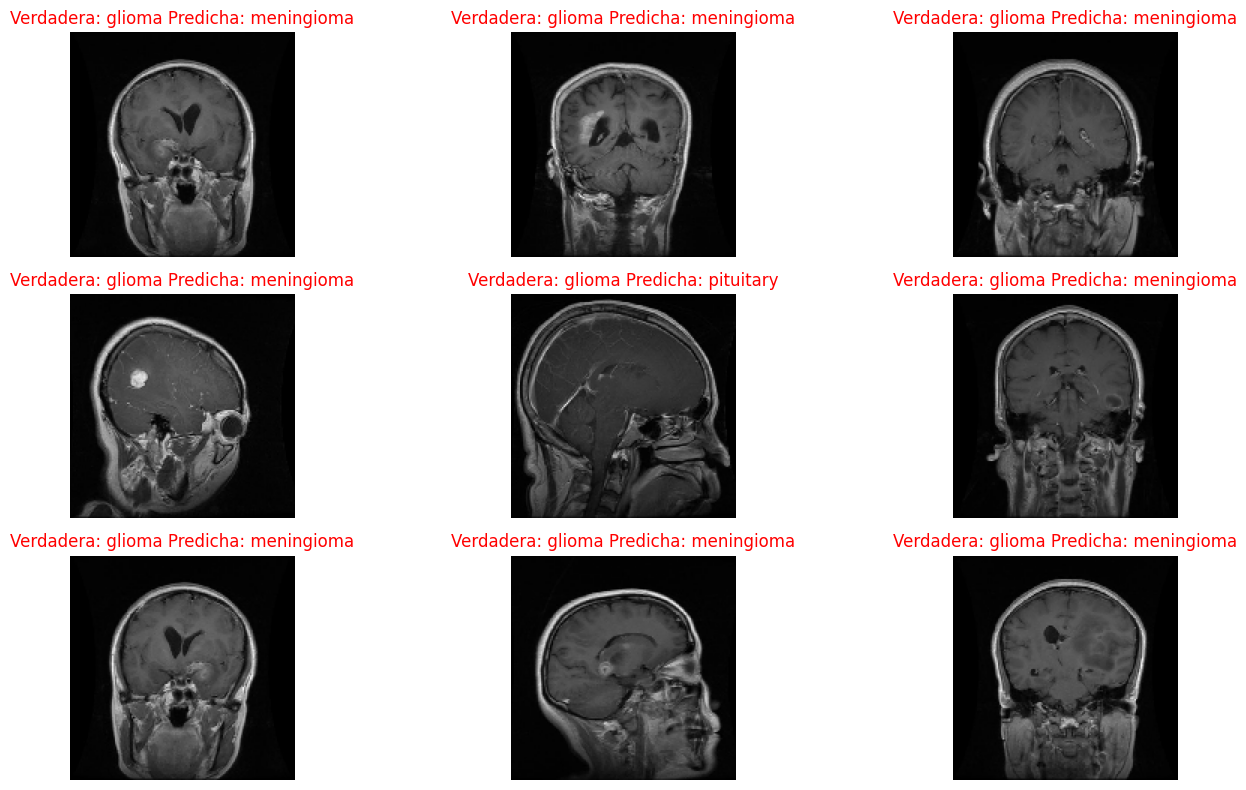

In [ ]:
# Obtener los nombres de los archivos de las imágenes de prueba
filenames = testing_set.filenames

# Comparar las etiquetas verdaderas con las predichas para encontrar aciertos y errores
correct_indices = np.where(predicted_classes == true_classes)[0]
incorrect_indices = np.where(predicted_classes != true_classes)[0]

print(f"Se encontraron {len(correct_indices)} predicciones correctas y {len(incorrect_indices)} incorrectas.")

# --- Visualizar Predicciones Correctas ---
print("--- Ejemplos de Predicciones Correctas ---")
plt.figure(figsize=(15, 8))
for i, idx in enumerate(correct_indices[:9]): # Mostramos las primeras 9 correctas
    plt.subplot(3, 3, i + 1)
    img_path = 'Testing/' + filenames[idx]
    img = load_img(img_path, target_size=(150, 150))
    
    true_label = class_labels[true_classes[idx]]
    predicted_label = class_labels[predicted_classes[idx]]
    
    plt.imshow(img)
    plt.title(f"Verdadera: {true_label} Predicha: {predicted_label}", color='blue')
    plt.axis('off')
plt.tight_layout()
plt.show()


# --- Visualizar Predicciones Incorrectas ---
if len(incorrect_indices) > 0:
    print("--- Ejemplos de Predicciones Incorrectas ---")
    plt.figure(figsize=(15, 8))
    # Mostramos un máximo de 9 incorrectas
    num_to_show = min(len(incorrect_indices), 9) 
    for i, idx in enumerate(incorrect_indices[:num_to_show]):
        plt.subplot(3, 3, i + 1)
        img_path = 'Testing/' + filenames[idx]
        img = load_img(img_path, target_size=(150, 150))
        
        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]
        
        plt.imshow(img)
        plt.title(f"Verdadera: {true_label} Predicha: {predicted_label}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("¡Excelente! No se encontraron predicciones incorrectas para mostrar.")